In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
import joblib
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [8]:
train = pd.read_csv(r'C:\Users\Clarice\Desktop\BC\242A\fp\etf_allocated_train.csv', delimiter=',')

print(train)

      ClientID  Age EducationLevel EmploymentStatus     JobTitle  \
0            1   46      Secondary         Employed     Services   
1            2   39      Secondary    Self-employed  Blue-collar   
2            3   48      Secondary    Self-employed     Services   
3            4   59      Secondary         Employed      Student   
4            5   38       Tertiary         Employed      Retired   
...        ...  ...            ...              ...          ...   
4994      4995   33       Tertiary          Retired     Services   
4995      4996   40       Tertiary         Employed        Admin   
4996      4997   49        Primary    Self-employed   Technician   
4997      4998   78      Secondary         Employed      Student   
4998      4999   50      Secondary    Self-employed        Admin   

     SalaryCategory  AnnualIncome  NetWorth  CreditScore RiskRating  ...  \
0               Mid      50548.83  31921.38          600       High  ...   
1               Low      28168.

In [9]:
test = pd.read_csv(r'C:\Users\Clarice\Desktop\BC\242A\fp\etf_allocated_test.csv', delimiter=',')

print(test)

      ClientID  Age EducationLevel EmploymentStatus     JobTitle  \
0         5000   30        Primary         Employed   Unemployed   
1         5001   35      Secondary       Unemployed  Blue-collar   
2         5002   35       Tertiary         Employed   Technician   
3         5003   19        Unknown         Employed   Technician   
4         5004   37      Secondary         Employed        Admin   
...        ...  ...            ...              ...          ...   
4995      9995   55      Secondary          Retired   Technician   
4996      9996   56      Secondary         Employed   Technician   
4997      9997   18      Secondary          Retired      Student   
4998      9998   32       Tertiary    Self-employed  Blue-collar   
4999      9999   46       Tertiary       Unemployed      Student   

     SalaryCategory  AnnualIncome  NetWorth  CreditScore RiskRating  ...  \
0               Low      11404.53   5000.00          689     Medium  ...   
1               Low      28303.

In [10]:
# --- FEATURES and TARGETS ---
feature_cols = [
    'Age','EducationLevel','EmploymentStatus','JobTitle','SalaryCategory','AnnualIncome',
    'NetWorth','CreditScore','RiskRating','AccountBalance','NumBankProducts',
    'HasCreditCard','HasMortgage','HasPersonalLoan','HasLifeInsurance',
    'HasMutualFunds','InvestmentPortfolioValue'
]

target_cols = ['US_Equity','Intl_Equity','Bonds','REIT','Cash']

# --- Quick data cleaning / ensure columns exist ---
missing = [c for c in feature_cols if c not in train.columns]
if missing:
    raise ValueError(f"Missing feature cols in CSV: {missing}")

missing_t = [c for c in target_cols if c not in train.columns]
if missing_t:
    raise ValueError(f"Missing target cols in CSV: {missing_t}")

# --- Convert yes/no flags to 0/1 if present ---
binary_flags = ['HasCreditCard','HasMortgage','HasPersonalLoan','HasLifeInsurance','HasMutualFunds']
for b in binary_flags:
    if b in train.columns:
        train[b] = train[b].map({'Yes':1,'No':0, 'yes':1,'no':0}).fillna(train[b])

# --- Split ---
X = train[feature_cols].copy()
y = train[target_cols].copy()

# Identify categorical vs numeric
categorical_cols = ['EducationLevel','EmploymentStatus','JobTitle','SalaryCategory','RiskRating']
numeric_cols = [c for c in feature_cols if c not in categorical_cols]

In [15]:
RANDOM_STATE = 42
# --- Preprocessing pipeline ---
preprocessor = ColumnTransformer(transformers=[
    ("num", StandardScaler(), numeric_cols),
    ("cat", OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
], remainder='passthrough')  # passthrough will keep binary flags if they weren't in numeric

# --- Prepare train/test (and holdout test) ---
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.15, random_state=RANDOM_STATE)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1765, random_state=RANDOM_STATE) 
# ~ 0.15 of full for validation (so final approx 70/15/15 split)

# Utility: fit, predict, evaluate
def evaluate_model(pipe, Xtr, ytr, Xv, yv, Xte=None, yte=None):
    pipe.fit(Xtr, ytr)
    pred_val = pipe.predict(Xv)
    def metrics(y_true, y_pred):
        results = {}
        for i,col in enumerate(y_true.columns):
            mae = mean_absolute_error(y_true.iloc[:,i], y_pred[:,i])
            rmse = mean_squared_error(y_true.iloc[:,i], y_pred[:,i], squared=False)
            r2 = r2_score(y_true.iloc[:,i], y_pred[:,i])
            results[col] = {'MAE':mae,'RMSE':rmse,'R2':r2}
        # averaged:
        results['avg_MAE'] = np.mean([results[c]['MAE'] for c in y_true.columns])
        results['avg_RMSE'] = np.mean([results[c]['RMSE'] for c in y_true.columns])
        results['avg_R2'] = np.mean([results[c]['R2'] for c in y_true.columns])
        return results
    val_metrics = metrics(yv, pred_val)
    test_metrics = None
    if Xte is not None and yte is not None:
        pred_test = pipe.predict(Xte)
        test_metrics = metrics(yte, pred_test)
    return pipe, val_metrics, test_metrics

In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test):

    # ---- TRAIN ----
    model.fit(X_train, y_train)

    # ---- PREDICT ----
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)

    # ---- METRICS ----
    def get_metrics(y_true, y_pred):
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)             # Instead of squared=False
        mae = mean_absolute_error(y_true, y_pred)
        r2  = r2_score(y_true, y_pred)
        return {"RMSE": rmse, "MAE": mae, "R2": r2}

    val_metrics  = get_metrics(y_val, y_val_pred)
    test_metrics = get_metrics(y_test, y_test_pred)

    return model, val_metrics, test_metrics


In [19]:
# --- MODEL 2: Gradient Boosting (HistGradientBoostingRegressor supports multioutput natively in newer sklearn) ---
try:
    # if HistGradientBoostingRegressor supports multioutput on your sklearn, use it directly:
    from sklearn.ensemble import HistGradientBoostingRegressor
    gb = HistGradientBoostingRegressor(max_iter=200, random_state=RANDOM_STATE)
    # wrap in MultiOutputRegressor if needed:
    gb_pipe = Pipeline([('pre', preprocessor), ('model', MultiOutputRegressor(gb))])
except Exception:
    # fallback to GradientBoostingRegressor (single-output) wrapped
    gb = GradientBoostingRegressor(n_estimators=200, random_state=RANDOM_STATE)
    gb_pipe = Pipeline([('pre', preprocessor), ('model', MultiOutputRegressor(gb))])

gb_pipe, gb_val_metrics, gb_test_metrics = evaluate_model(gb_pipe, X_train, y_train, X_val, y_val, X_test, y_test)
print("GB validation metrics:", gb_val_metrics)
print("GB test metrics:", gb_test_metrics)
joblib.dump(gb_pipe, "gb_etf_model.joblib")

GB validation metrics: {'RMSE': np.float64(1.3737842953315507e-09), 'MAE': 1.1160748693820703e-09, 'R2': 1.0}
GB test metrics: {'RMSE': np.float64(1.3742036022939139e-09), 'MAE': 1.116466842177033e-09, 'R2': 1.0}


['gb_etf_model.joblib']

In [22]:
# --- Summarize results in a simple table ---
def summarize(name, valm, testm):
    return {
        'model': name,
        'val_MAE': valm['MAE'],
        'val_RMSE': valm['RMSE'],
        'val_R2': valm['R2'],
        'test_MAE': (testm or {}).get('MAE'),
        'test_RMSE': (testm or {}).get('RMSE'),
        'test_R2': (testm or {}).get('R2')
    }


summary = pd.DataFrame([
    summarize('RandomForest', rf_val_metrics, rf_test_metrics),
    summarize('GradientBoosting', gb_val_metrics, gb_test_metrics),
    summarize('MLP', mlp_val_metrics, mlp_test_metrics)
])
print("\nSummary:")
print(summary)


Summary:
              model       val_MAE      val_RMSE    val_R2      test_MAE  \
0      RandomForest  1.600000e-04  3.651484e-03  0.999997  1.800000e-04   
1  GradientBoosting  1.116075e-09  1.373784e-09  1.000000  1.116467e-09   
2               MLP  8.430767e-02  1.602569e-01  0.793157  8.149772e-02   

      test_RMSE   test_R2  
0  3.354102e-03  0.999998  
1  1.374204e-09  1.000000  
2  1.356084e-01  0.794728  


In [23]:
final = pd.read_csv(r'C:\Users\Clarice\Desktop\BC\242A\fp\final.csv', delimiter=',')

print(final)

      ClientID  Age  Gender MaritalStatus EducationLevel EmploymentStatus  \
0            1   46    Male      Divorced      Secondary         Employed   
1            2   39  Female       Married      Secondary    Self-employed   
2            3   48    Male       Married      Secondary    Self-employed   
3            4   59  Female       Married      Secondary         Employed   
4            5   38    Male       Married       Tertiary         Employed   
...        ...  ...     ...           ...            ...              ...   
9995      9996   56    Male        Single      Secondary         Employed   
9996      9997   18    Male       Married      Secondary          Retired   
9997      9998   32    Male        Single       Tertiary    Self-employed   
9998      9999   46  Female       Married       Tertiary       Unemployed   
9999     10000   48    Male       Widowed      Secondary         Employed   

         JobTitle   Region SalaryCategory CustomerSegment  ...  \
0        

formal

In [43]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor

# =========================================================
# 1. LOAD DATA
# =========================================================
df = pd.read_csv(r'C:\Users\Clarice\Desktop\BC\242A\fp\final.csv', delimiter=',')


# =========================================================
# 2. SELECT FEATURES & TARGETS
# =========================================================
columns_keep = [
    'Age',
    'MaritalStatus',
    'EducationLevel',
    'AnnualIncome',
    'NetWorth',
    'AccountBalance',
    'InvestmentPortfolioValue',
    'SalaryCategory',
    'RiskRating',
    'CustomerSegment',
    'HasMortgage',
    'HasPersonalLoan'
]

target_cols = ['US_Equity', 'International_Equity', 'Bonds', 'REIT', 'Cash']

X = df[columns_keep].copy()
y = df[target_cols].copy()

# =========================================================
# 3. COLUMN TRANSFORMER (SCALING NUMERIC + ONE-HOT ENCODE CATEGORICAL)
# =========================================================
numerical_columns = X.select_dtypes(include=['number']).columns.tolist()
categorical_columns = X.select_dtypes(exclude=['number']).columns.tolist()

column_transformer = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns),
    ]
)

# Transform X
X_scaled = column_transformer.fit_transform(X)

# =========================================================
# 4. TRAIN / TEST SPLIT
# =========================================================
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# =========================================================
# 5. GRADIENT BOOSTING (PER TARGET)
# =========================================================
# Tuned Gradient Boosting parameters (customize if needed)
gb_params = {
    "n_estimators": 600,
    "learning_rate": 0.03,
    "max_depth": 3,
    "subsample": 0.9,
    "random_state": 42
}

models = {}
y_pred_dict = {}

print("\n=========== Training Gradient Boosting Models ===========")
for col in target_cols:
    print(f"\n➡ Training model for target: {col}")

    model = GradientBoostingRegressor(**gb_params)

    model.fit(X_train, y_train[col])

    models[col] = model
    y_pred_dict[col] = model.predict(X_test)

# =========================================================
# 6. EVALUATION — PER TARGET + OVERALL
# =========================================================
y_pred = np.column_stack([y_pred_dict[c] for c in target_cols])

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n==============================")
print(" FINAL GRADIENT BOOSTING RESULTS")
print("==============================")
print(f"RMSE: {rmse:.6f}")
print(f"R² : {r2:.6f}")

print("\nPer-target metrics:")
for i, col in enumerate(target_cols):
    rmse_i = np.sqrt(mean_squared_error(y_test[col], y_pred[:, i]))
    r2_i = r2_score(y_test[col], y_pred[:, i])
    print(f"{col:20s} RMSE = {rmse_i:.6f}   R² = {r2_i:.6f}")

# =========================================================
# 7. CHECK COLUMN TYPES (DEBUGGING)
# =========================================================
print("\nNumeric columns:", numerical_columns)
print("Categorical columns:", categorical_columns)



=========== Training Gradient Boosting Models ===========

➡ Training model for target: US_Equity

➡ Training model for target: International_Equity

➡ Training model for target: Bonds

➡ Training model for target: REIT

➡ Training model for target: Cash

 FINAL GRADIENT BOOSTING RESULTS
RMSE: 0.060327
R² : 0.487694

Per-target metrics:
US_Equity            RMSE = 0.062723   R² = 0.487694
International_Equity RMSE = 0.047020   R² = 0.488175
Bonds                RMSE = 0.047063   R² = 0.487238
REIT                 RMSE = 0.031361   R² = 0.487717
Cash                 RMSE = 0.094090   R² = 0.487646

Numeric columns: ['Age', 'AnnualIncome', 'NetWorth', 'AccountBalance', 'InvestmentPortfolioValue']
Categorical columns: ['MaritalStatus', 'EducationLevel', 'SalaryCategory', 'RiskRating', 'CustomerSegment', 'HasMortgage', 'HasPersonalLoan']


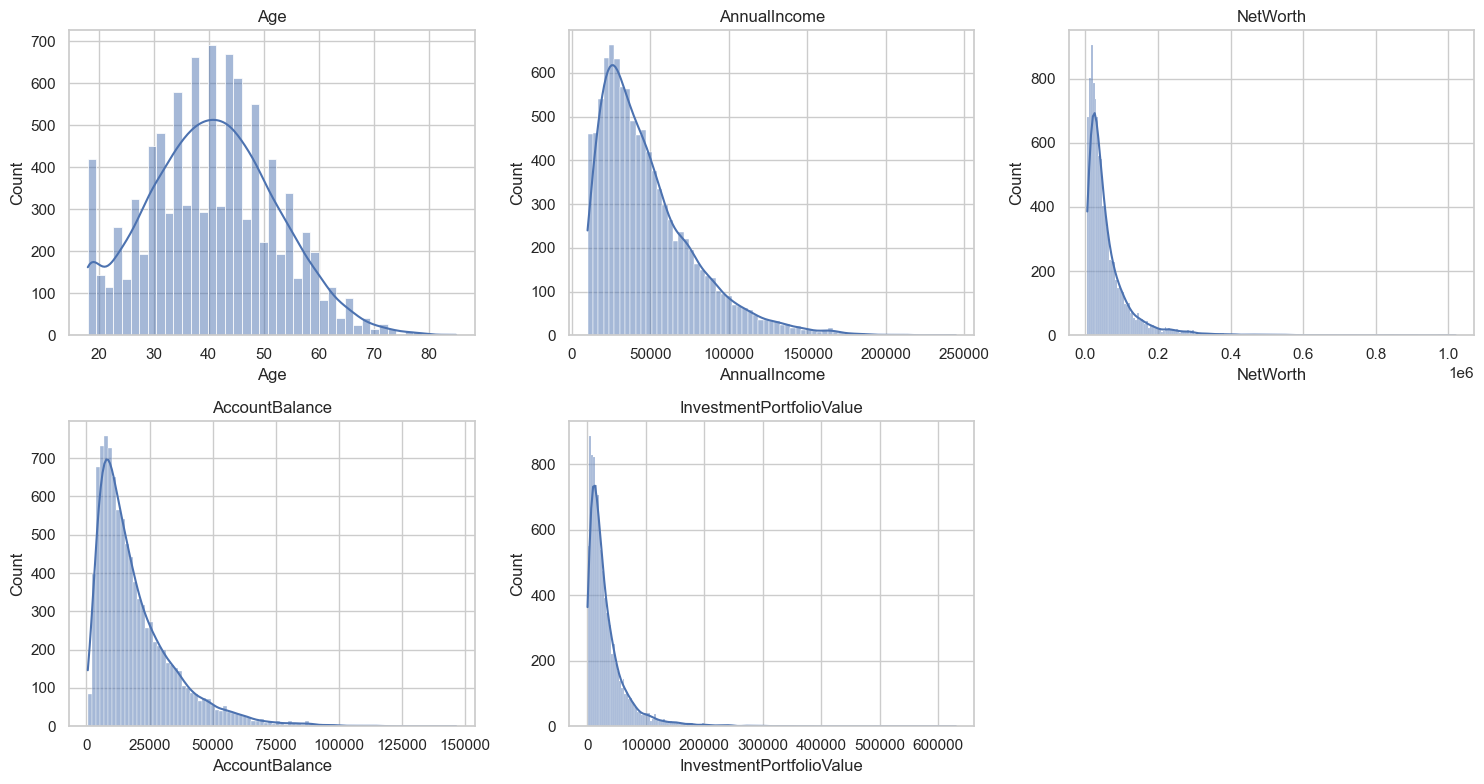

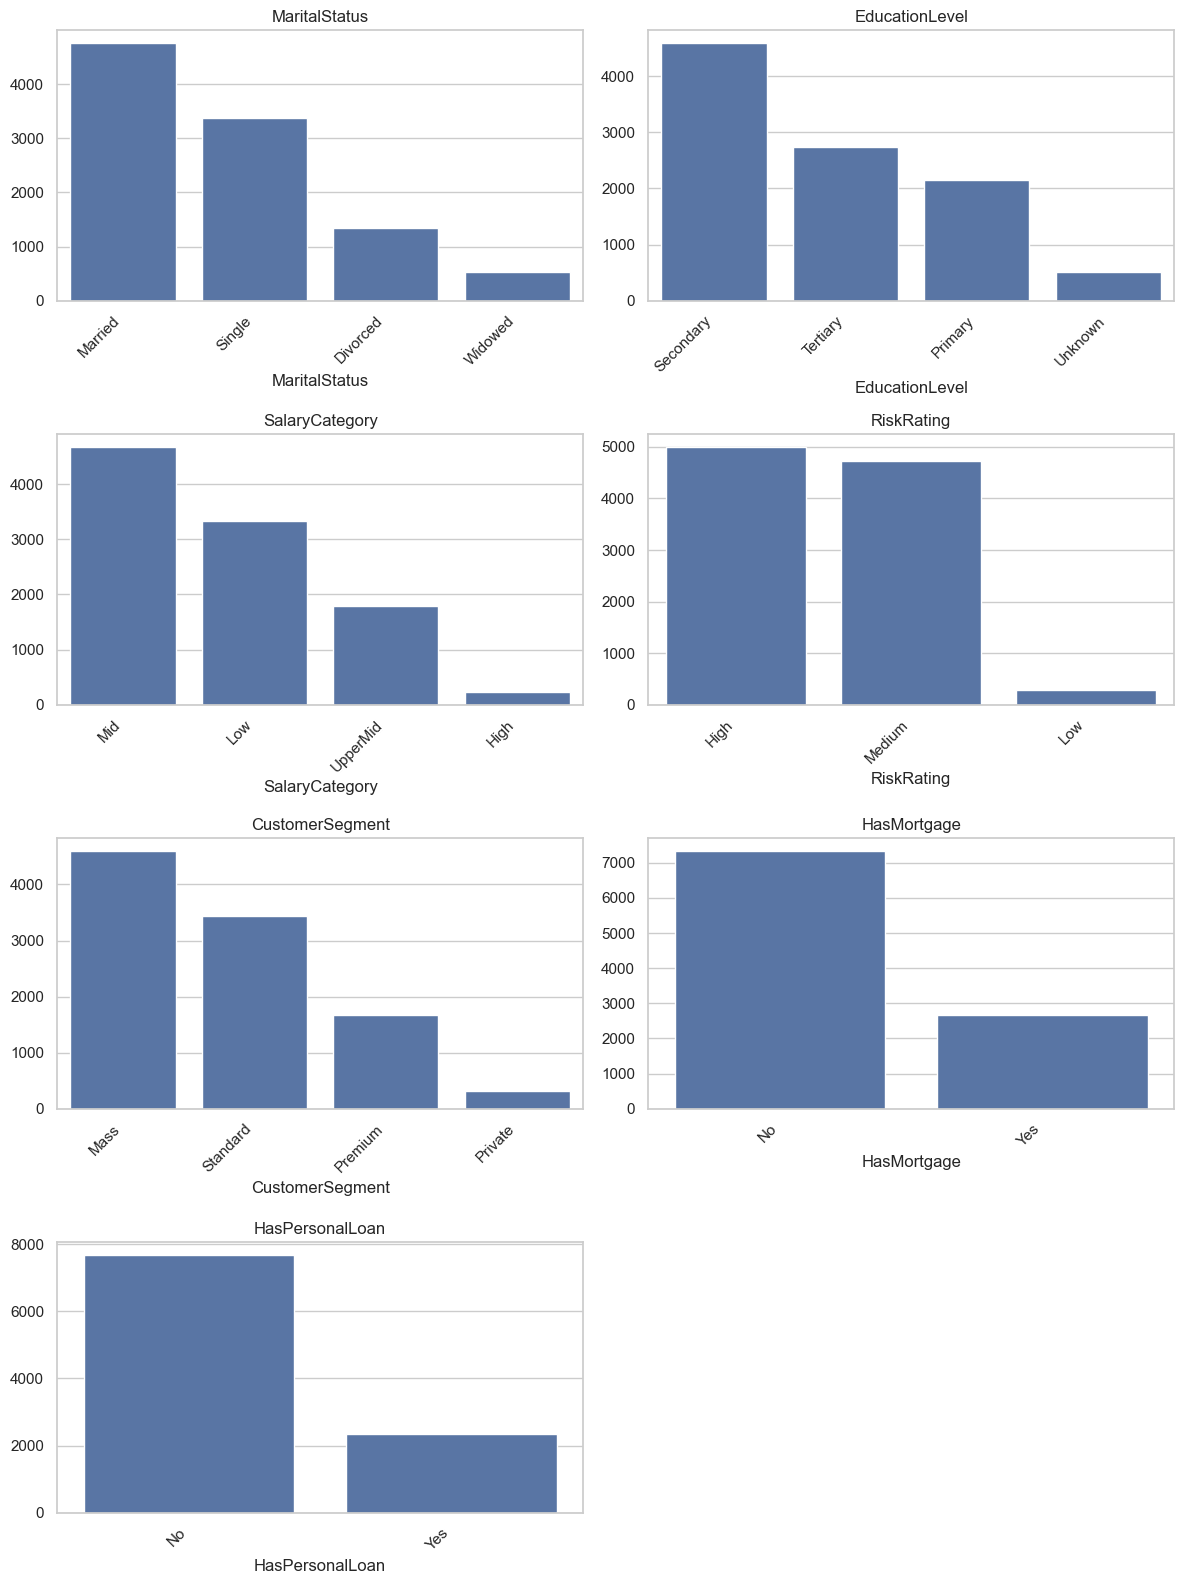

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# ============================================================
# FIX: Recompute column lists to match the real DataFrame X
# ============================================================
numerical_columns = X.select_dtypes(include=['number']).columns.tolist()
categorical_cols = X.select_dtypes(exclude=['number']).columns.tolist()

# ----- Numerical Columns -----
n_num = len(numerical_columns)
n_cols = 3
n_rows = (n_num + n_cols - 1) // n_cols

plt.figure(figsize=(5 * n_cols, 4 * n_rows))

for i, col in enumerate(numerical_columns, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(X[col], kde=True)
    plt.title(col)

plt.tight_layout()
plt.show()

# ----- Categorical Columns -----
n_cat = len(categorical_cols)
n_cols = 2
n_rows = (n_cat + n_cols - 1) // n_cols

plt.figure(figsize=(6 * n_cols, 4 * n_rows))

for i, col in enumerate(categorical_cols, 1):

    # Skip if column missing (extra safety)
    if col not in X.columns:
        print(f"⚠ Skipping missing column: {col}")
        continue

    plt.subplot(n_rows, n_cols, i)
    
    # Top 10 categories only
    value_counts = X[col].value_counts().head(10)

    sns.barplot(x=value_counts.index, y=value_counts.values)
    plt.title(col)
    plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


In [47]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor

# =========================================================
# 1. LOAD DATA
# =========================================================
df = pd.read_csv(r'C:\Users\Clarice\Desktop\BC\242A\fp\final.csv', delimiter=',')

# =========================================================
# 2. SELECT FEATURES & TARGETS
# =========================================================
columns_keep = [
    'Age',
    'MaritalStatus',
    'EducationLevel',
    'AnnualIncome',
    'NetWorth',
    'AccountBalance',
    'InvestmentPortfolioValue',
    'SalaryCategory',
    'RiskRating',
    'CustomerSegment',
    'HasMortgage',
    'HasPersonalLoan'
]

target_cols = ['US_Equity', 'International_Equity', 'Bonds', 'REIT', 'Cash']

X = df[columns_keep].copy()
y = df[target_cols].copy()

# =========================================================
# 3. COLUMN TRANSFORMER
# =========================================================
numerical_columns = X.select_dtypes(include=['number']).columns.tolist()
categorical_columns = X.select_dtypes(exclude=['number']).columns.tolist()

column_transformer = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns),
    ]
)

X_scaled = column_transformer.fit_transform(X)

# =========================================================
# 4. TRAIN / TEST SPLIT
# =========================================================
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# =========================================================
# 5. GRADIENT BOOSTING (PER TARGET)
# =========================================================
gb_params = {
    "n_estimators": 600,
    "learning_rate": 0.03,
    "max_depth": 3,
    "subsample": 0.9,
    "random_state": 42
}

models = {}
y_pred_dict = {}

print("\n=========== Training Gradient Boosting Models ===========")
for col in target_cols:
    print(f"\n➡ Training model for target: {col}")

    model = GradientBoostingRegressor(**gb_params)
    model.fit(X_train, y_train[col])

    models[col] = model
    y_pred_dict[col] = model.predict(X_test)

# =========================================================
# 6. EVALUATION
# =========================================================
y_pred = np.column_stack([y_pred_dict[c] for c in target_cols])

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n==============================")
print(" FINAL GRADIENT BOOSTING RESULTS")
print("==============================")
print(f"RMSE: {rmse:.6f}")
print(f"R² : {r2:.6f}")

print("\nPer-target metrics:")
for i, col in enumerate(target_cols):
    rmse_i = np.sqrt(mean_squared_error(y_test[col], y_pred[:, i]))
    r2_i = r2_score(y_test[col], y_pred[:, i])
    print(f"{col:20s} RMSE = {rmse_i:.6f}   R² = {r2_i:.6f}")

# =========================================================
# 7. COLUMN TYPE CHECK
# =========================================================
print("\nNumeric columns:", numerical_columns)
print("Categorical columns:", categorical_columns)


# =========================================================
# 8. PREDICTED ETF ALLOCATION (PERCENT FORMAT)
# =========================================================
# Choose a sample to predict — here we use the first test sample
sample_index = 0
sample_features = X_test[sample_index].reshape(1, -1)

# Predict each ETF category using trained models
sample_pred = {col: models[col].predict(sample_features)[0] for col in target_cols}

# Normalize to sum to 1 (if model predictions do not sum to 100%)
total = sum(sample_pred.values())
normalized_pred = {k: v / total for k, v in sample_pred.items()}

# Convert to percentage format
percent_pred = {k: f"{int(v * 100)}%" for k, v in normalized_pred.items()}

print("\n=======================================")
print("Predicted ETF allocation (percent format):")
print(percent_pred)
print("=======================================")



=========== Training Gradient Boosting Models ===========

➡ Training model for target: US_Equity

➡ Training model for target: International_Equity

➡ Training model for target: Bonds

➡ Training model for target: REIT

➡ Training model for target: Cash

 FINAL GRADIENT BOOSTING RESULTS
RMSE: 0.060327
R² : 0.487694

Per-target metrics:
US_Equity            RMSE = 0.062723   R² = 0.487694
International_Equity RMSE = 0.047020   R² = 0.488175
Bonds                RMSE = 0.047063   R² = 0.487238
REIT                 RMSE = 0.031361   R² = 0.487717
Cash                 RMSE = 0.094090   R² = 0.487646

Numeric columns: ['Age', 'AnnualIncome', 'NetWorth', 'AccountBalance', 'InvestmentPortfolioValue']
Categorical columns: ['MaritalStatus', 'EducationLevel', 'SalaryCategory', 'RiskRating', 'CustomerSegment', 'HasMortgage', 'HasPersonalLoan']

Predicted ETF allocation (percent format):
{'US_Equity': '17%', 'International_Equity': '13%', 'Bonds': '16%', 'REIT': '8%', 'Cash': '43%'}


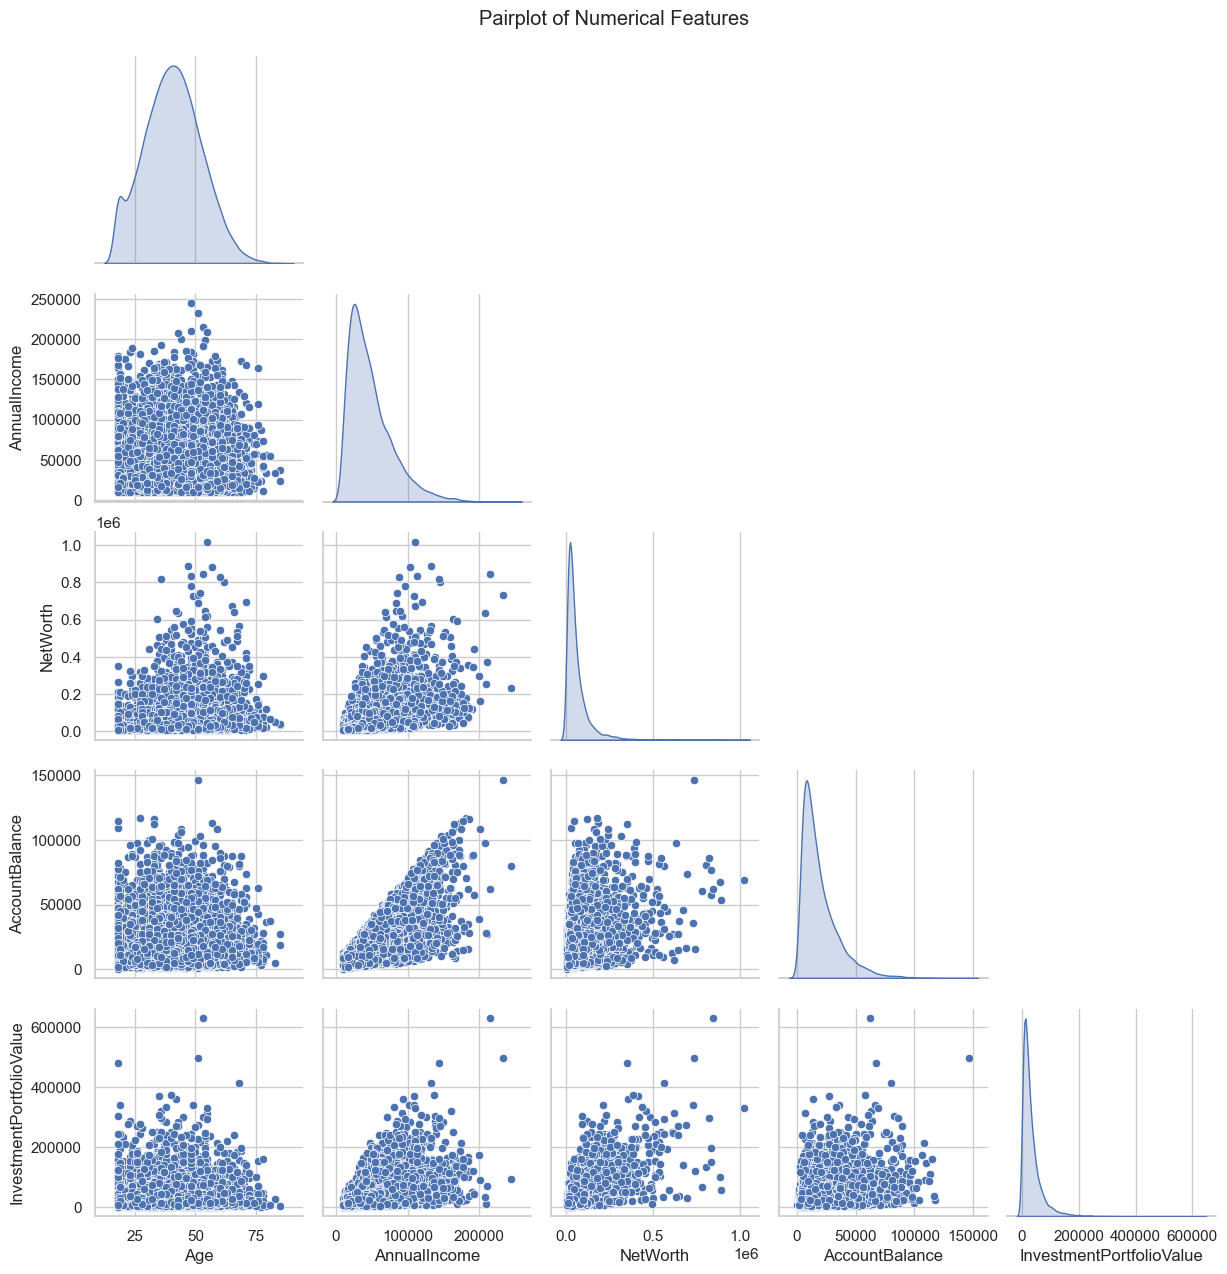

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pairplot using numerical columns only
sns.pairplot(X[numerical_columns], diag_kind="kde", corner=True)
plt.suptitle("Pairplot of Numerical Features", y=1.02)
plt.show()


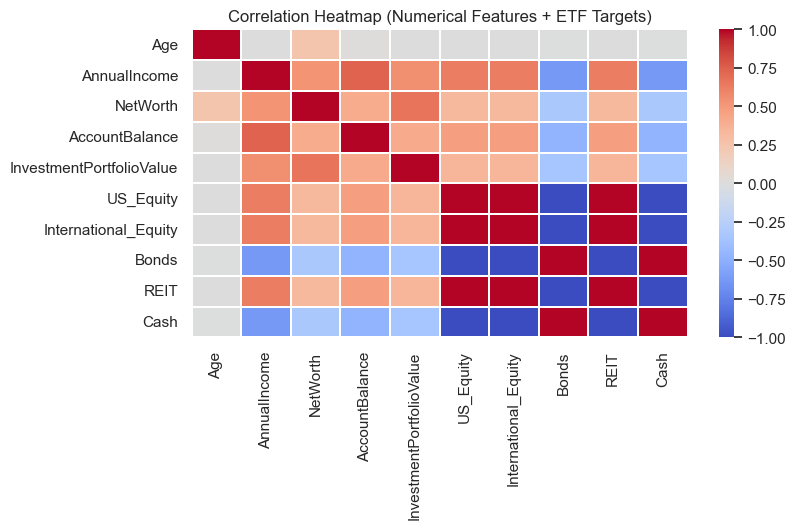

In [51]:
plt.figure(figsize=(8, 4))

# Combine numerical features + target ETF allocations
corr_df = pd.concat([X[numerical_columns], y], axis=1)

corr_matrix = corr_df.corr()

sns.heatmap(
    corr_matrix,
    cmap="coolwarm",
    annot=False,
    linewidths=0.3
)

plt.title("Correlation Heatmap (Numerical Features + ETF Targets)")
plt.show()


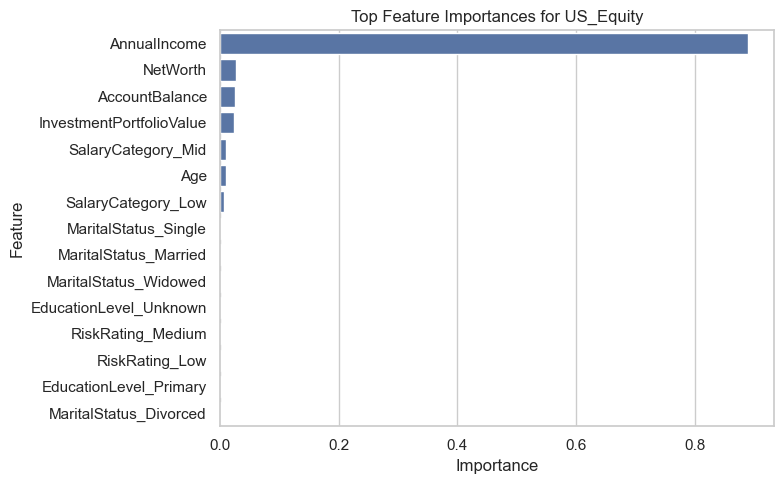

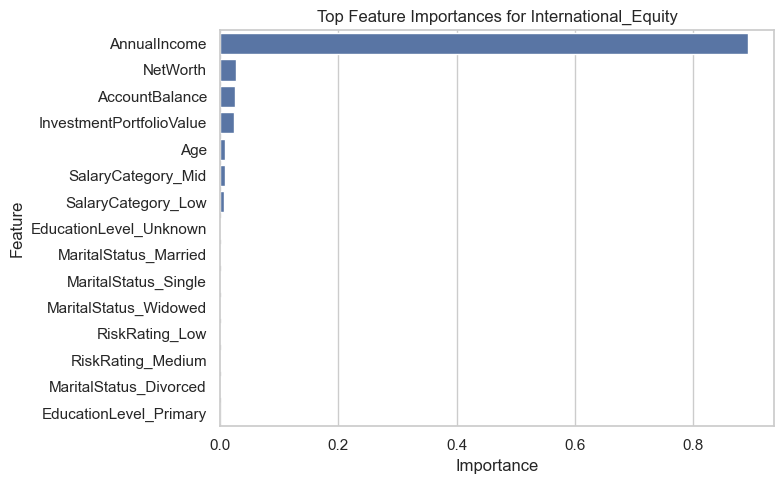

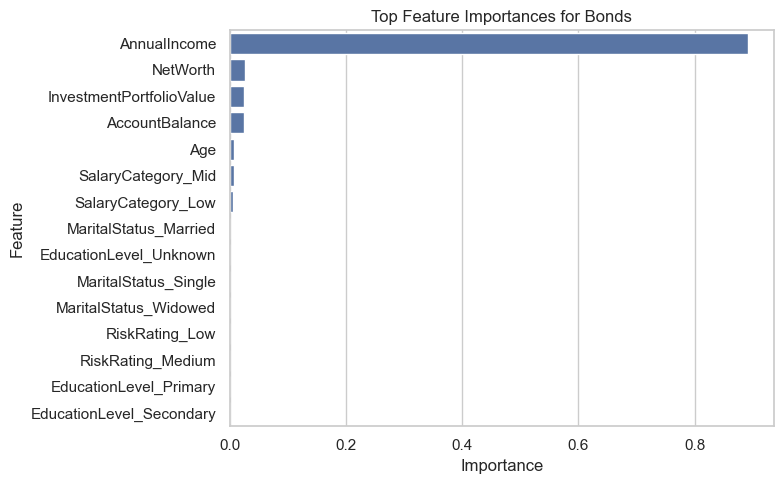

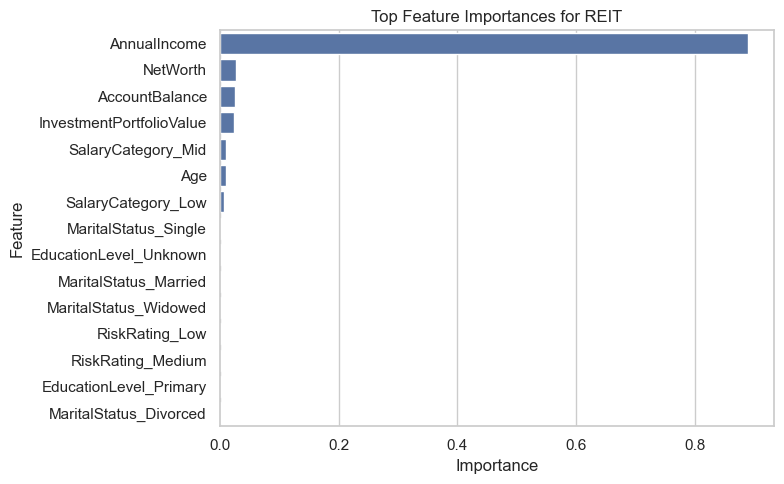

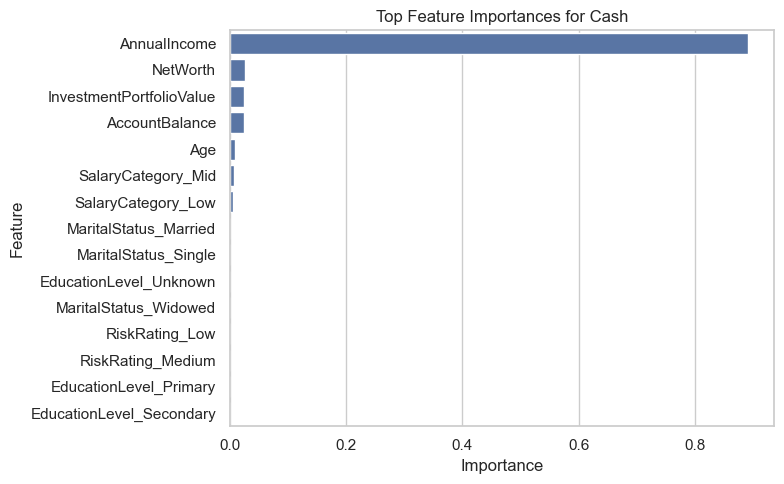

In [52]:
for col in target_cols:
    model = models[col]
    importances = model.feature_importances_
    
    # Get transformed feature names
    onehot = column_transformer.named_transformers_['cat']
    cat_feature_names = onehot.get_feature_names_out(categorical_cols)
    
    feature_names = numerical_columns + list(cat_feature_names)
    
    importance_df = pd.DataFrame({
        "Feature": feature_names,
        "Importance": importances
    }).sort_values("Importance", ascending=False)
    
    plt.figure(figsize=(8, 5))
    sns.barplot(data=importance_df.head(15), x="Importance", y="Feature")
    plt.title(f"Top Feature Importances for {col}")
    plt.tight_layout()
    plt.show()


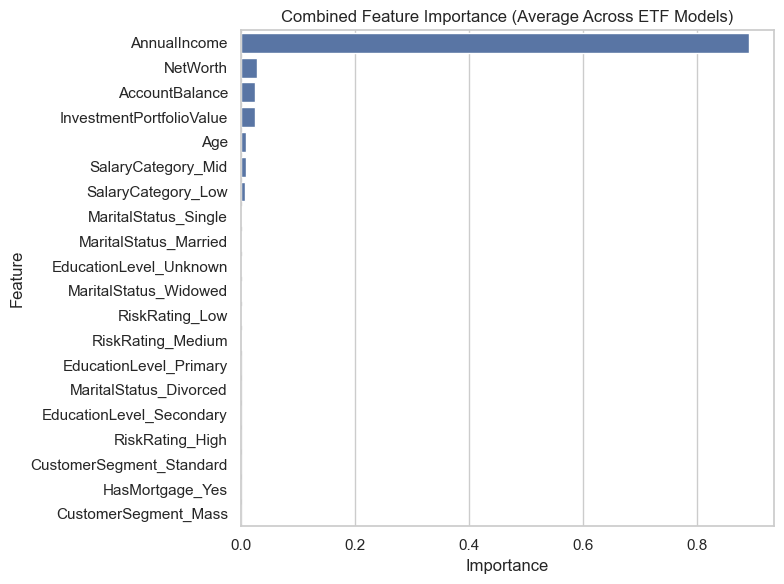

In [53]:
combined_importances = np.zeros(len(feature_names))

for col in target_cols:
    combined_importances += models[col].feature_importances_

combined_importances /= len(target_cols)

combined_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": combined_importances
}).sort_values("Importance", ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(data=combined_df.head(20), x="Importance", y="Feature")
plt.title("Combined Feature Importance (Average Across ETF Models)")
plt.tight_layout()
plt.show()


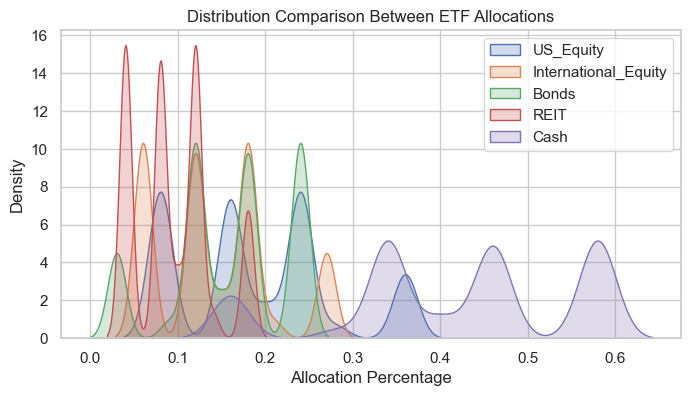

In [54]:
plt.figure(figsize=(8, 4))

for col in target_cols:
    sns.kdeplot(y[col], fill=True, label=col)

plt.title("Distribution Comparison Between ETF Allocations")
plt.xlabel("Allocation Percentage")
plt.legend()
plt.show()


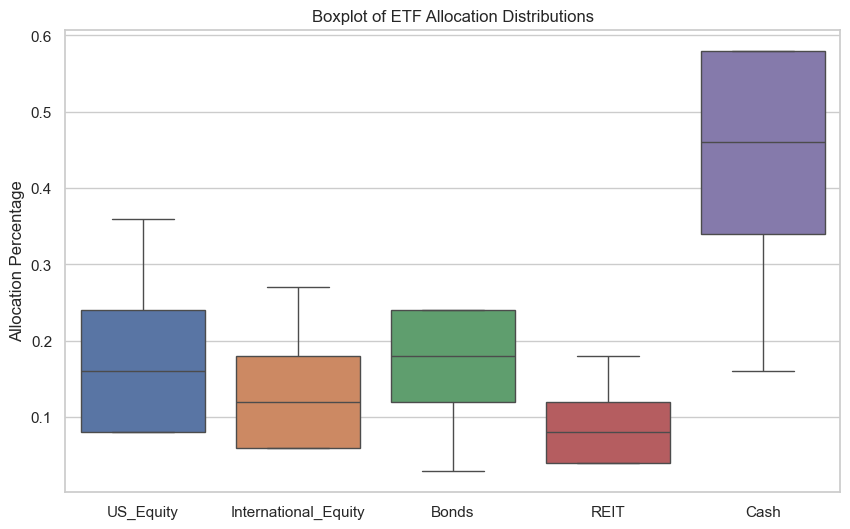

In [55]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=y[target_cols])
plt.title("Boxplot of ETF Allocation Distributions")
plt.ylabel("Allocation Percentage")
plt.show()
